In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import (PandasTools,
                        Draw,
                        Descriptors,
                        MACCSkeys,
                        rdFingerprintGenerator)

In [4]:
molecule_dataset = pd.read_csv("Aromatase_compounds_lipinski.csv",
    usecols=["molecule_chembl_id", "smiles", "PIC50"])

print(f"Number of molecules in dataset: {len(molecule_dataset)}")
molecule_dataset.head(5)

Number of molecules in dataset: 1742


,molecule_chembl_id,smiles,PIC50
0,CHEMBL1672980,COc1ccc(-c2cc(N(Cc3ccc(OS(N)(=O)=O)cc3)n3cnnc3...,10.823909
1,CHEMBL1672978,N#Cc1ccc(N(Cc2ccc(OS(N)(=O)=O)c(Cl)c2)n2cnnc2)...,10.823909
2,CHEMBL1672979,N#Cc1ccc(N(Cc2ccc(OS(N)(=O)=O)c(Br)c2)n2cnnc2)...,10.744727
3,CHEMBL310735,C[C@H]1CC2C3CCC(=O)C3(C)CCC2C2(C)CCCC=C12,10.431798
4,CHEMBL305205,C[C@@H]1CC2C3CCC(=O)C3(C)CCC2C2(C)CCCC=C12,10.309804


We will conduct a similarity search (virtual screening) using aromatase inhibitor Letrozole for similar molecules in our data set of molecules.

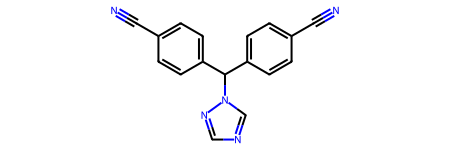

In [5]:
Letrozole = Chem.MolFromSmiles("C1=CC(=CC=C1C#N)C(C2=CC=C(C=C2)C#N)N3C=NC=N3")
Letrozole

In [7]:
# Generate MACCS and Morgan fingerprints for Letrozole.
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

maccs_fp_query = MACCSkeys.GenMACCSKeys(Letrozole)
circular_fp_query = fpg.GetCountFingerprint(Letrozole)

In [8]:
# Generate MACCS and Morgan fingerprints for all molecules in our dataset.

PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles")
circular_fp_list = molecule_dataset["ROMol"].apply(fpg.GetCountFingerprint).tolist()
maccs_fp_list = molecule_dataset["ROMol"].apply(MACCSkeys.GenMACCSKeys).tolist()

In [9]:
# Calculate the Tanimoto similarity between the query molecule (Letrozole) and 
# all molecules our dataset (using MACCS and Morgan fingerprints).

molecule_dataset["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(
                                     maccs_fp_query, maccs_fp_list)

molecule_dataset["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(
                                      circular_fp_query, circular_fp_list)


In [10]:
# Calculate Dice similarity for query molecule (Letrozole) and
# all molecules in file (MACCS, Morgan).

molecule_dataset["dice_maccs"] = DataStructs.BulkDiceSimilarity(maccs_fp_query, maccs_fp_list)

molecule_dataset["dice_morgan"] = DataStructs.BulkDiceSimilarity(
                                  circular_fp_query, circular_fp_list)

In [15]:
molecule_dataset[["smiles", "tanimoto_maccs", "tanimoto_morgan", \
                   "dice_maccs", "dice_morgan"]].head(3)

,smiles,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,COc1ccc(-c2cc(N(Cc3ccc(OS(N)(=O)=O)cc3)n3cnnc3...,0.378788,0.229008,0.549451,0.372671
1,N#Cc1ccc(N(Cc2ccc(OS(N)(=O)=O)c(Cl)c2)n2cnnc2)...,0.373134,0.215385,0.543478,0.354430
2,N#Cc1ccc(N(Cc2ccc(OS(N)(=O)=O)c(Br)c2)n2cnnc2)...,0.373134,0.215385,0.543478,0.354430


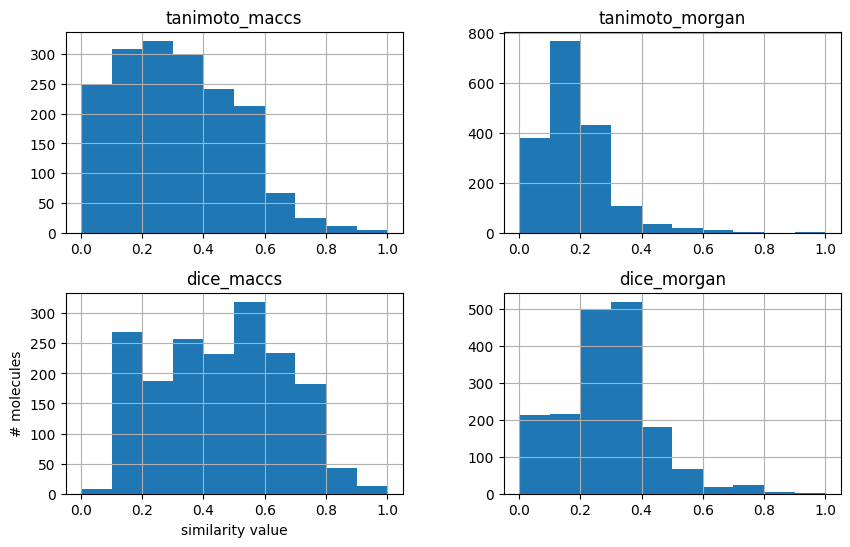

In [16]:
# Comparing two different fingerprints (MACCS and Morgan fingerprints).

fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
molecule_dataset.hist(["tanimoto_maccs"], ax=axes[0, 0])
molecule_dataset.hist(["tanimoto_morgan"], ax=axes[0, 1])
molecule_dataset.hist(["dice_maccs"], ax=axes[1, 0])
molecule_dataset.hist(["dice_morgan"], ax=axes[1, 1])
axes[1, 0].set_xlabel("similarity value")
axes[1, 0].set_ylabel("# molecules")
fig;

#### Visualize most similar molecules.

In [19]:
# Visually inspect the structure of Letrozole in comparison to the most 
# similar molecules in our ranking.

molecule_dataset.sort_values(["tanimoto_morgan"], ascending=False).head(3)

,molecule_chembl_id,smiles,PIC50,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
139,CHEMBL1444,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,8.214670,<rdkit.Chem.rdchem.Mol object at 0x000002114A4...,1.000000,1.000000,1.000000,1.000000
145,CHEMBL519937,N#Cc1ccc(C(c2ccc(O)cc2)n2cncn2)cc1,8.142668,<rdkit.Chem.rdchem.Mol object at 0x000002114A4...,0.781250,0.785714,0.877193,0.880000
150,CHEMBL224789,N#Cc1ccc(C(c2ccc(C#N)cc2)n2ccnn2)cc1,8.096910,<rdkit.Chem.rdchem.Mol object at 0x000002114A4...,0.925926,0.753425,0.961538,0.859375


In [ ]:
# Show Letrozole and its most similar molecules alongside the molecules’ bioactivities.

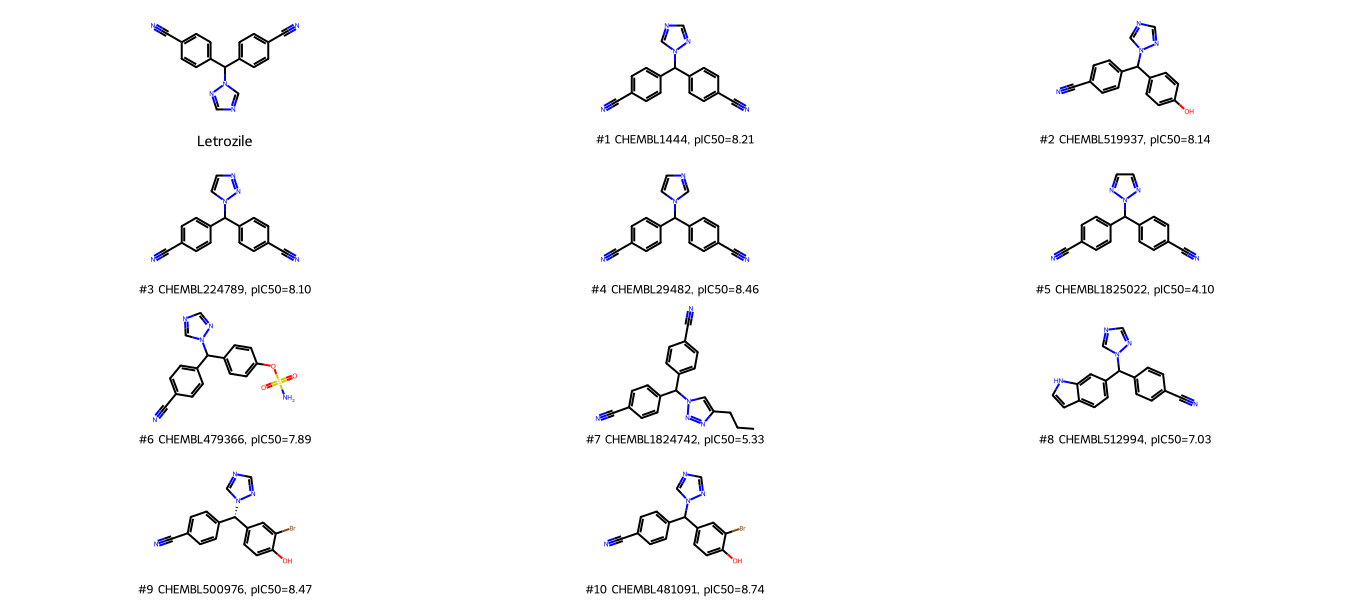

In [22]:
top_n_molecules = 10
top_molecules = molecule_dataset.sort_values(["tanimoto_morgan"], ascending=False).reset_index()
top_molecules = top_molecules[:top_n_molecules]
legends = [
    f"#{index+1} {molecule['molecule_chembl_id']}, pIC50={molecule['PIC50']:.2f}"
    for index, molecule in top_molecules.iterrows()]

Chem.Draw.MolsToGridImage(
    mols=[Letrozole] + top_molecules["ROMol"].tolist(),
    legends=(["Letrozile"] + legends),
    molsPerRow=3,
    subImgSize=(450, 150),)

We now check how well the similarity search is able to distinguish between active and inactive molecules based on our dataset. Therefore, we use the bioactivity values, which we collected from ChEMBL for each molecule.

In order to validate our virtual screening and see the ratio of detected active molecules, we generate an enrichment plot.

Enrichment plots show

    the ratio of top-ranked molecules (x-axis) from the whole dataset vs.

    the ratio of active molecules (y-axis) from the whole dataset.

We compare the Tanimoto similarity for MACCS and Morgan fingerprints.

In order to decide whether we treat a molecule as active or inactive, we apply the commonly used PIC50 cutoff value of 6.3.

In [27]:
def get_enrichment_data(molecules, similarity_measure, pic50_cutoff):
    """
    Calculates x and y values for enrichment plot:
        x - % ranked dataset
        y - % true actives identified
    """

    # Get number of molecules in data set
    molecules_all = len(molecules)

    # Get number of active molecules in data set
    actives_all = sum(molecules["PIC50"] >= pic50_cutoff)

    # Initialize a list that will hold the counter for actives and molecules while iterating through our dataset
    actives_counter_list = []

    # Initialize counter for actives
    actives_counter = 0

    # Note: Data must be ranked for enrichment plots:
    # Sort molecules by selected similarity measure
    molecules.sort_values([similarity_measure], ascending=False, inplace=True)

    # Iterate over the ranked dataset and check each molecule if active (by checking bioactivity)
    for value in molecules["PIC50"]:
        if value >= pic50_cutoff:
            actives_counter += 1
        actives_counter_list.append(actives_counter)

    # Transform number of molecules into % ranked dataset
    molecules_percentage_list = [i / molecules_all for i in range(1, molecules_all + 1)]

    # Transform number of actives into % true actives identified
    actives_percentage_list = [i / actives_all for i in actives_counter_list]

    # Generate DataFrame with x and y values as well as label
    enrichment = pd.DataFrame(
        {
            "% ranked dataset": molecules_percentage_list,
            "% true actives identified": actives_percentage_list,
        }
    )

    return enrichment

In [29]:
# get the enrichment for MACCS and Morgan fingerprints (using the Tanimoto similarity).
pic50_cutoff = 6.3

similarity_measures = ["tanimoto_maccs", "tanimoto_morgan"]

enrichment_data = {
    similarity_measure: get_enrichment_data(molecule_dataset, similarity_measure, pic50_cutoff)
    for similarity_measure in similarity_measures}


enrichment_data["tanimoto_maccs"].head()

,% ranked dataset,% true actives identified
0,0.000574,0.001333
1,0.001148,0.001333
2,0.001722,0.002667
3,0.002296,0.002667
4,0.002870,0.002667


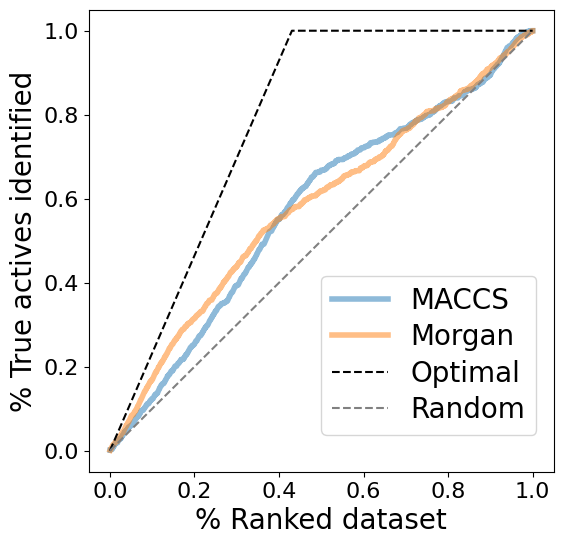

In [33]:
# Plot the enrichment data next to the optimal and random enrichment curve.

fig, ax = plt.subplots(figsize=(6, 6))

fontsize = 20

# Plot enrichment data
for similarity_measure, enrichment in enrichment_data.items():
    ax = enrichment.plot(
        ax=ax,
        x="% ranked dataset",
        y="% true actives identified",
        label=similarity_measure,
        alpha=0.5,
        linewidth=4,
    )
ax.set_ylabel("% True actives identified", size=fontsize)
ax.set_xlabel("% Ranked dataset", size=fontsize)

# Plot optimal curve: Ratio of actives in dataset
ratio_actives = sum(molecule_dataset["PIC50"] >= pic50_cutoff) / len(molecule_dataset)
ax.plot(
    [0, ratio_actives, 1],
    [0, 1, 1],
    label="Optimal curve",
    color="black",
    linestyle="--",
)

# Plot random curve
ax.plot([0, 1], [0, 1], label="Random curve", color="grey", linestyle="--")

plt.tick_params(labelsize=16)
plt.legend(
    labels=["MACCS", "Morgan", "Optimal", "Random"],
    loc=(0.5, 0.08),
    fontsize=fontsize,
    labelspacing=0.3,
)

# Save plot -- use bbox_inches to include text boxes
plt.savefig(
     "enrichment_plot.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

plt.show()

In [40]:
def calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff):
    """
    Get the experimental enrichment factor for a given percentage of the ranked dataset.
    """

    # Keep only molecules that meet the cutoff
    enrichment = enrichment[
        enrichment["% ranked dataset"] <= ranked_dataset_percentage_cutoff / 100
    ]
    # Get highest percentage of actives and the corresponding percentage of actives
    highest_enrichment = enrichment.iloc[-1]
    enrichment_factor = round(100 * float(highest_enrichment["% true actives identified"]), 1)
    return enrichment_factor



def calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff):
    """
    Get the random enrichment factor for a given percentage of the ranked dataset.
    """

    enrichment_factor_random = round(float(ranked_dataset_percentage_cutoff), 1)
    return enrichment_factor_random


def calculate_enrichment_factor_optimal(molecules, ranked_dataset_percentage_cutoff, pic50_cutoff):
    """
    Get the optimal random enrichment factor for a given percentage of the ranked dataset.
    """

    ratio = sum(molecules["PIC50"] >= pic50_cutoff) / len(molecules) * 100
    if ranked_dataset_percentage_cutoff <= ratio:
        enrichment_factor_optimal = round(100 / ratio * ranked_dataset_percentage_cutoff, 1)
    else:
        enrichment_factor_optimal = 100.0
    return enrichment_factor_optimal

In [41]:
ranked_dataset_percentage_cutoff = 5

for similarity_measure, enrichment in enrichment_data.items():
    enrichment_factor = calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff)
    print(f"Experimental EF for {ranked_dataset_percentage_cutoff} % of ranked dataset ({similarity_measure}): {enrichment_factor}%")


Experimental EF for 5 % of ranked dataset (tanimoto_maccs): 6.0%
Experimental EF for 5 % of ranked dataset (tanimoto_morgan): 8.1%


In [42]:
enrichment_factor_random = calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff)
print(f"Random EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_random}%")

enrichment_factor_optimal = calculate_enrichment_factor_optimal(
    molecule_dataset, ranked_dataset_percentage_cutoff, pic50_cutoff)

print(f"Optimal EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_optimal}%")

Random EF for 5% of ranked dataset: 5.0%
Optimal EF for 5% of ranked dataset: 11.6%
